In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

Warning: this doesn't work. This was from Donald's code that I just changed a few things

In [3]:
def generate(string): 
    a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
    b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])

    maxMats = 50
    dataPoints = 1000
    prevMat = -1
    consecutiveA = 0
    consecutiveB = 0
    mat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    


    for j in range(dataPoints):
        mat = np.array([[1,0,0],[0,1,0],[0,0,1]])
        nextMat = random.randint(0,1)
        if nextMat == 0: 
            mat = np.matmul(a, mat)
            consecutiveA = consecutiveA + 1 
            consecutiveB = 0 
            prevMat = 0
        elif nextMat == 1:
            mat = np.matmul(b, mat)
            consecutiveB = consecutiveB + 1
            consecutiveA = 0
            prevMat = 1
        numOfMatrices = random.randint(1, maxMats)
        for i in range(numOfMatrices):
            nextMat = random.randint(0,1)
            if nextMat == 0 and consecutiveA == 2: 
                map = np.matmul(b, mat)
                consecutiveB = consecutiveB + 1
                consecutiveA = 0
                prevMat = 1
            if nextMat == 1 and consecutiveB == 2:
                mat = np.matmul(a, mat)
                consecutiveA = consecutiveA + 1 
                consecutiveB = 0 
                prevMat = 0
            elif (nextMat == 0):
                mat = np.matmul(a, mat)
                consecutiveA = consecutiveA + 1 
                consecutiveB = 0 
                prevMat = 0
            elif (nextMat == 1):
                mat = np.matmul(b, mat)
                consecutiveB = consecutiveB + 1
                consecutiveA = 0
                prevMat = 1
            
        if j == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
        else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
# mat[0][0] = mat[0][0]  % 7
# mat [0][1] = mat[0][1]  % 7
# mat[0][2] = mat[0][2]  % 7
# mat [1][0] = mat[1][0]  % 7
# mat [1][1] = mat[1][1]  % 7
# mat [1][1] = mat[1][1]  % 7
    df.to_csv(string, index = False)

In [4]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(9, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 2, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item

        scheduler.step()
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [5]:
generate('matrices_train.csv')
generate('matrices_test.csv')
df = pd.read_csv("matrices_train.csv")
just_input = df.drop('last', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())
desired_output = torch.tensor(df['last'].tolist(), dtype=torch.float32).long()
df

,00,01,02,10,11,12,20,21,22,last
0,-47,-24,-78,-142,-71,-234,87,45,145,1
1,-27,-25,-57,-77,-71,-162,51,48,109,1
2,15,5,22,7,2,10,-12,-3,-17,0
3,27,25,57,77,71,162,-342,-315,-719,0
4,963,-263,126,971,-265,127,-7812,2133,-1022,0
...,...,...,...,...,...,...,...,...,...,...
995,1,-4,-1,0,-2,-1,0,3,1,0
996,288,-1262,-369,284,-1243,-363,-261,1143,334,0
997,172,41,164,156,22,123,-153,-33,-140,1
998,-697,-322,-126,-702,-325,-127,636,294,115,1


/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_16955/363369511.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 0.7363004088401794
Epoch [1/500], Loss: 0.7363
total loss: 0.7582065463066101
Epoch [2/500], Loss: 0.7582
total loss: 0.6879680156707764
Epoch [3/500], Loss: 0.6880
total loss: 0.6778313517570496
Epoch [4/500], Loss: 0.6778
total loss: 0.6684020161628723
Epoch [5/500], Loss: 0.6684
total loss: 0.667506217956543
Epoch [6/500], Loss: 0.6675
total loss: 0.6763600707054138
Epoch [7/500], Loss: 0.6764
total loss: 0.673717737197876
Epoch [8/500], Loss: 0.6737
total loss: 0.6928824186325073
Epoch [9/500], Loss: 0.6929
total loss: 0.6994746923446655
Epoch [10/500], Loss: 0.6995
total loss: 0.6922014951705933
Epoch [11/500], Loss: 0.6922
total loss: 0.6644048094749451
Epoch [12/500], Loss: 0.6644
total loss: 0.6601322889328003
Epoch [13/500], Loss: 0.6601
total loss: 0.705714225769043
Epoch [14/500], Loss: 0.7057
total loss: 0.7157435417175293
Epoch [15/500], Loss: 0.7157
total loss: 0.7202609181404114
Epoch [16/500], Loss: 0.7203
total loss: 0.7284219264984131
Epoch [17/500], Loss:

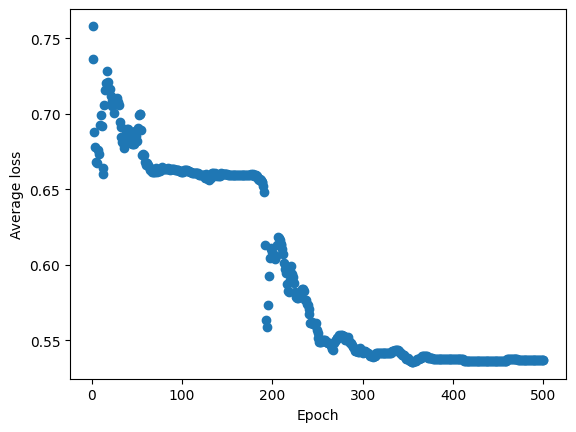

In [6]:

# Train the model
trained_model = train_model(input_data, desired_output, 500, viz_accuracy=True)


In [7]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)
    print(test_output)

    predicted_classes = torch.argmax(test_output, dim=1)
    print(predicted_classes)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)
    print(test_output_compare)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [8]:
test_df = pd.read_csv("matrices_test.csv")
just_input_test = test_df.drop('last', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last'].tolist(), dtype=torch.float32).long()

test_model(trained_model, input_data_test, desired_output)

tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.6165e-06],
        [1.0000e+00, 0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.9777e-10],
        [0.0000e+00, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0,

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_16955/2208809294.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.7609999775886536